### Initialization

In [ ]:
import torch
from torch import optim
from torch import distributions
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import imageio
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
#torch.autograd.set_detect_anomaly(True) 

In [ ]:
dtype = torch.float32
device = torch.device("cuda:0")



---



## Load Observations, Serial Interaval and Delay Distribution

### Load serial_interval and delay_distr

In [ ]:
data = pd.read_csv('covid19model.csv')
data.head()

,date,hospit,serial_interval,delay_distr
0,2020-02-17,0,0.046535,0.013006
1,2020-02-18,0,0.087065,0.030046
2,2020-02-19,0,0.112061,0.044674
3,2020-02-20,0,0.119346,0.055473
4,2020-02-21,0,0.114540,0.062422


### Load Observations

In [ ]:
# Load Observations denmark
obs_data = pd.read_excel(r'observations.xlsx')
obs_data.head()

,Unnamed: 0,Date,Number_of_deaths,Number_of_hospitalizations,NewPositive_pcr,PosPct_pcr,Tested_pcr,NewPositive_antigen,PosPct_antigen,Tested_antigen
0,0,2020-03-11,1,10,207,23.6,882,0,0.0,0
1,1,2020-03-12,0,18,44,6.6,676,0,0.0,0
2,2,2020-03-13,0,26,33,4.7,710,0,0.0,0
3,3,2020-03-14,1,24,37,6.4,583,0,0.0,0
4,4,2020-03-15,2,33,45,6.2,726,0,0.0,0


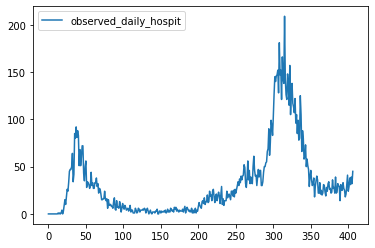

In [ ]:
Use_Toy_Data = False
Use_New_Observations = False
if Use_Toy_Data:
    toy_data = []
    for i in range(num_observations):
      val = np.sin(i/5)+1
      toy_data.append(val)
    observed_daily_hospit = torch.tensor(toy_data, requires_grad=False, device=device, dtype=dtype)

elif Use_New_Observations:
    observed_daily_hospit = torch.tensor(obs_data.Number_of_hospitalizations, requires_grad=False, device=device, dtype=dtype)

else:
    observed_daily_hospit = torch.tensor(data.hospit, requires_grad=False, device=device, dtype=dtype)

plt.plot(observed_daily_hospit.cpu().detach().numpy(), label='observed_daily_hospit')
plt.legend()
plt.show()

In [ ]:
cero = torch.tensor(0., requires_grad=False, device=device, dtype=dtype)
num_impute = 6
num_observations = len(observed_daily_hospit)
population = torch.tensor(5793636, requires_grad=False, device=device, dtype=dtype)
pi = torch.tensor(data.delay_distr, requires_grad=False, device=device, dtype=dtype)
serial_interval = torch.tensor(data.serial_interval, requires_grad=False, device=device, dtype=dtype)

## Load Model Input Data

### Load Google Mobility Data

In [ ]:
# Load Google Mobility Data (as input for RNN)
mob_data = pd.read_excel(r'denmark_google_mobility.xlsx', index_col=0)
mob_data['date'] = pd.to_datetime(mob_data['date'], format='%Y-%m-%d')

if Use_New_Observations:
    mob_data = mob_data[25:457]
else:
    mob_data = mob_data[2:409]
mob_data = mob_data.iloc[: , 1:]
mob_data.reset_index(drop=True, inplace=True)
mob_data.head()

,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,2020-02-17,-3,-1,0,-3,-2,1
1,2020-02-18,1,1,9,-1,-1,1
2,2020-02-19,0,0,12,-2,-1,1
3,2020-02-20,1,-1,-3,-1,-2,1
4,2020-02-21,1,1,15,-1,-3,1


### Load Weather Data

In [ ]:
df_weather_data = pd.read_csv('denmark_weather_data.csv', delimiter=';', index_col=0, decimal=',')
df_weather_data['DateTime'] = pd.to_datetime(df_weather_data['DateTime'], format='%Y-%m-%d')
df_weather_data = df_weather_data[16:423].reset_index(drop=True)
df_weather_data.head()

,DateTime,Hours_of_Rain,Hours_of_Sun,Lowest_Temp,Highest_Temp,Avg_Temp
0,2020-02-17,1.3,1.2,3.9,9.2,6.6
1,2020-02-18,3.8,3.0,2.3,8.5,5.4
2,2020-02-19,4.9,3.8,1.0,7.9,4.6
3,2020-02-20,10.4,0.1,1.2,8.3,5.0
4,2020-02-21,2.3,2.5,1.9,8.9,5.5


### Load and Preprocess Vaccination Data

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv')
vaccination = df[['date','people_fully_vaccinated']][df['iso_code'] == 'DNK'].reset_index(drop=True)
vaccine_effectivenes = 0.9
vaccination['daily_vaccinated'] = vaccination['people_fully_vaccinated'].diff(periods=-1)*-1
vaccination['vaccine_inmune'] = vaccination['people_fully_vaccinated'].shift(14)
vaccination.fillna(0, inplace=True)
vaccination['vaccine_inmune'] = vaccination['vaccine_inmune'] * vaccine_effectivenes
vaccine_inmune = torch.tensor(np.concatenate((np.zeros(num_observations - 103 ), vaccination['vaccine_inmune'].iloc[:103].to_numpy())),  device=device, dtype=dtype)

## LSTM

### Create LSTM Input Data

In [ ]:
model_input_data = pd.merge(left=mob_data, right=df_weather_data, left_on='date', right_on='DateTime', how='inner')
model_input_data = model_input_data.drop('DateTime', axis=1)
model_input_data

,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,Hours_of_Rain,Hours_of_Sun,Lowest_Temp,Highest_Temp,Avg_Temp
0,2020-02-17,-3,-1,0,-3,-2,1,1.3,1.2,3.9,9.2,6.6
1,2020-02-18,1,1,9,-1,-1,1,3.8,3.0,2.3,8.5,5.4
2,2020-02-19,0,0,12,-2,-1,1,4.9,3.8,1.0,7.9,4.6
3,2020-02-20,1,-1,-3,-1,-2,1,10.4,0.1,1.2,8.3,5.0
4,2020-02-21,1,1,15,-1,-3,1,2.3,2.5,1.9,8.9,5.5
...,...,...,...,...,...,...,...,...,...,...,...,...
402,2021-03-25,-18,-1,101,-37,-29,9,0.0,6.2,-0.2,13.5,6.1
403,2021-03-26,-21,-2,90,-39,-29,9,0.6,2.6,-0.5,14.2,7.5
404,2021-03-27,-27,-1,51,-40,-2,5,3.8,3.1,1.1,12.5,5.6
405,2021-03-28,-21,-12,27,-44,-2,5,5.3,0.3,2.0,10.0,5.8


### Preprocess LSTM Input Data

In [ ]:
cols_mob = [
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline']

cols_weather = ['Hours_of_Rain', 'Hours_of_Sun',	'Lowest_Temp',	'Highest_Temp',	'Avg_Temp']

cols_sentiment = ['anger_intensity', 'fear_intensity', 'fear_intensity', 'joy_intensity']

In [ ]:
cols = cols_mob + cols_weather

In [ ]:
scaler = MinMaxScaler()
np_model_input_data = model_input_data[cols].to_numpy()
scaler.fit(np_model_input_data)
np_model_input_data_scaled = scaler.transform(np_model_input_data)
model_input_data_t = torch.tensor(np_model_input_data_scaled, dtype=dtype, device=device)
model_input_data_t.shape

torch.Size([407, 11])

### Initialize LSTM Model

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size, dtype=dtype, device=device),
                            torch.zeros(1,1,self.hidden_layer_size, dtype=dtype, device=device))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions

In [ ]:
input_size = len(cols)
hidden_size = 10
output_size = 1

lstm = LSTM(input_size=input_size, hidden_layer_size=hidden_size, output_size=output_size).to(device)

# Model Definition

## Set Initial Values

In [ ]:
def bij_transform(prime, lower, upper):
    # Recieves a value in [-inf, inf] and returns value in [low, upper]
    bij = 1 / (1 + torch.exp(-prime / upper))
    scale = upper - lower
    return scale * bij + lower

def bij_transform_inv(transf, lower, upper):
    return -torch.log(((upper - lower) / (transf - lower) - 1) ** upper)

In [ ]:
R0_prime = torch.tensor(bij_transform_inv(torch.tensor(3.6), 2, 5), requires_grad=True, device=device, dtype=dtype)
phi_prime = torch.tensor(bij_transform_inv(torch.tensor(25), 0, 50), requires_grad=True, device=device, dtype=dtype)
sigma_prime = torch.tensor(bij_transform_inv(torch.tensor(0.1), 0.00001, 0.5), requires_grad=True, device=device, dtype=dtype)
alpha_prime = torch.tensor(bij_transform_inv(torch.tensor(0.01), 0.001, 0.05), requires_grad=True, device=device, dtype=dtype)

sigma = bij_transform(sigma_prime, 0.01, 0.5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy 

In [ ]:
epsilon_t = torch.zeros(num_observations, device=device)
epsilon_t[0] = torch.distributions.Normal(cero, sigma.detach()).rsample()
for t in range(1, num_observations):
    epsilon_t[t] = torch.distributions.Normal(epsilon_t[t - 1].detach(), sigma.detach()).rsample()
epsilon_t = epsilon_t * 0.7
epsilon_t.requires_grad_(True)

tensor([-0.0074, -0.0917,  0.0062, -0.0379, -0.1631, -0.2505, -0.2759, -0.3124,
        -0.2972, -0.2804, -0.2746, -0.2509, -0.3262, -0.2940, -0.3286, -0.4503,
        -0.4033, -0.4125, -0.4549, -0.4833, -0.6010, -0.4941, -0.6117, -0.6330,
        -0.6008, -0.6136, -0.6262, -0.6712, -0.6458, -0.6191, -0.6463, -0.5938,
        -0.4665, -0.3522, -0.3091, -0.2810, -0.3439, -0.4090, -0.5306, -0.6448,
        -0.6918, -0.7511, -0.6415, -0.5624, -0.4866, -0.4425, -0.3046, -0.3821,
        -0.4664, -0.4892, -0.4886, -0.4284, -0.3830, -0.3017, -0.2558, -0.2495,
        -0.3598, -0.3645, -0.4205, -0.5418, -0.6804, -0.7592, -0.7397, -0.9390,
        -0.9576, -0.9666, -1.0936, -1.0343, -1.0547, -1.0886, -1.2441, -1.2286,
        -1.1851, -1.1557, -1.1728, -1.1962, -1.3001, -1.2371, -1.2766, -1.3674,
        -1.3742, -1.4124, -1.3680, -1.4377, -1.6354, -1.6171, -1.6014, -1.4733,
        -1.5638, -1.5372, -1.5448, -1.4766, -1.4507, -1.5506, -1.5343, -1.5604,
        -1.5529, -1.7339, -1.7019, -1.56

## Define Forward Pass

In [ ]:
def transform_variables(R0_prime, sigma_prime, phi_prime, alpha_prime):
    R0 = bij_transform(R0_prime, lower=2, upper=5)
    sigma = bij_transform(sigma_prime, lower=0.01, upper=0.5)
    phi = bij_transform(phi_prime, lower=0.00001, upper=50)
    alpha = bij_transform(alpha_prime, lower=0.001, upper=0.05)
    return R0, sigma, phi, alpha

In [ ]:
def forward_pass(input_data, epsilon_t, training_days, forecasting_days):
    days_to_calc = training_days + forecasting_days
    lstm_input_data = input_data[:days_to_calc]

    if forecasting_days != 0:
      epsilon_t_forecasting = torch.zeros(num_observations, device=device, dtype=dtype, requires_grad=False)
      epsilon_t_forecasting[training_days:days_to_calc] = torch.ones(forecasting_days, dtype=dtype, device=device) * epsilon_t[training_days-1]
      epsilon_t[training_days:days_to_calc] = cero
      epsilon_t = epsilon_t + epsilon_t_forecasting

      #Use Mean Values for the forecasting period and not actual data!
      #mean = torch.mean(lstm_input_data[-7:], 0, keepdim=True)
      #lstm_input_data = torch.cat((lstm_input_data, torch.cat([mean]*(forecasting_days))), dim = 0)


      
    # Seed initial Infections
    newly_infected = torch.zeros(days_to_calc, device=device, dtype=dtype)  # number of newly infected
    cumulative_infected = torch.zeros(days_to_calc, device=device)  # cumulative number of infected
    inmune = torch.zeros(days_to_calc, device=device)
    St = torch.zeros(days_to_calc, device=device)  # fraction of susceptible population

    # seed initial infection / impute first num_impute days
    newly_infected[0:num_impute] = torch.tensor(5.) # y.clone()
    cumulative_infected[0] = 0.
    cumulative_infected[1:num_impute] = torch.cumsum(newly_infected[0:num_impute - 1].clone(), dim=0) 
    inmune[0:num_impute] = cumulative_infected[0:num_impute].clone() + vaccine_inmune[0:num_impute].clone()


    St[0:num_impute] = torch.tensor([torch.maximum(population - x, torch.tensor(0)) / population for x in
                                     inmune[0:num_impute]])
    
    # Initialize eta_t
    eta_t = torch.zeros(days_to_calc, device=device)  # transformed reproduction number
    # calculate Rt: the basic reproduction number
    # basic reproduction number as a latent random walk
    beta_0 = torch.log(R0) 
    eta_t[0] = beta_0
    lstm_prediction = lstm(lstm_input_data).view(-1).cuda()
    eta_t[1:days_to_calc] = lstm_prediction[0:days_to_calc - 1] + beta_0 + epsilon_t[0:days_to_calc - 1] 
    Rt = torch.exp(eta_t)

    # Calc Infections
    # Initialize effectively_infectious
    effectively_infectious = torch.zeros(days_to_calc, device=device)  # effective number of infectious individuals

    # calculate infections
    for t in range(num_impute, days_to_calc):
        # Update cumulative newly_infected
        cumulative_infected[t] = cumulative_infected[t - 1] + newly_infected[t - 1]
        inmune[t] = cumulative_infected[t] + vaccine_inmune[t]
        # Adjusts for portion of pop that are susceptible
        St[t] = torch.maximum(population - inmune[t], cero) / population
        # effective number of infectous individuals
        ni_temp = newly_infected[:t].view(1, 1, -1).clone()
        si_temp = torch.flip(serial_interval, (0,))[-t:].view(1, 1, -1)
        effectively_infectious[t] = torch.nn.functional.conv1d(ni_temp, si_temp)

        newly_infected[t] = St[t].clone() * Rt[t] * effectively_infectious[t].clone()
    
    # calc hospitalizations
    # Initialize expected_daily_hospit
    expected_daily_hospit = torch.zeros(days_to_calc, device=device)  # expected number of daily hospitalizations

    # calculate expected number of hospitalizations
    expected_daily_hospit[0] = (1e-15) * newly_infected[0]
    for t in range(1, days_to_calc):
        ni_temp = newly_infected[:t].view(1, 1, -1)
        pi_temp = torch.flip(pi, (0,))[-t - 1:-1].view(1, 1, -1)
        expected_daily_hospit[t] = torch.nn.functional.conv1d(ni_temp, pi_temp)
    expected_daily_hospit = alpha * expected_daily_hospit

    return expected_daily_hospit, lstm_prediction, beta_0, eta_t

## Define Loss Functions

In [ ]:
def calc_random_walk_loss(epsilon_t, sigma, training_days):
    loc = epsilon_t[:training_days-1]
    scale = sigma * torch.ones(training_days - 1, device=device)
    mvn = distributions.multivariate_normal.MultivariateNormal(loc, scale_tril=torch.diag(scale))
    ll = mvn.log_prob(epsilon_t[1:training_days])
    return -ll

In [ ]:
def calc_mse(expected, observed, training_days):
    diff = expected - observed[:training_days]
    square = diff.square()
    msr = square.mean()
    return msr

In [ ]:
dist_phi = distributions.normal.Normal(loc=torch.tensor([25], device=device), scale=torch.tensor([10], device=device))
dist_R0 = distributions.normal.Normal(loc=torch.tensor([3.6], device=device), scale=torch.tensor([0.8], device=device))
dist_alpha = distributions.normal.Normal(loc=torch.tensor([0.01], device=device), scale=torch.tensor([0.01], device=device))
dist_sigma = distributions.normal.Normal(loc=torch.tensor([0.05], device=device), scale=torch.tensor([0.03], device=device))

def calc_prior_loss(R0, sigma, phi, alpha):
    # log likelihood wrt. our prior ("regularisation")
    # ll stands for log-likelihood

    ll = torch.tensor(0.0, device=device)

    ll += dist_R0.log_prob(R0)[0] # neg

    ll += dist_sigma.log_prob(sigma)[0]

    ll += dist_phi.log_prob(phi)[0]

    ll += dist_alpha.log_prob(alpha)[0]

    return -ll

# Optimization

In [ ]:
# Visualitation
# Parameter vis
R0_vis = []
sigma_vis = []
phi_vis = []
alpha_vis = []
lstm_vis = []

# loss vis
loss_vis = []
comp_loss_vis = []
rw_loss_vis = []
prior_loss_vis = []

# performance evaluation vis
mae_vis = []

## Train Model

In [ ]:
training_days = 250
forecasting_days = 14
cols_to_plot_1 = ['workplaces_percent_change_from_baseline', 'Avg_Temp']
cols_to_plot_2 = ['Hours_of_Rain', 'Hours_of_Sun']
#plt.plot(model_input_data[cols_to_plot_2][:training_days])
#plt.show()

In [ ]:
epochs = 8000
params = [epsilon_t, R0_prime, sigma_prime , phi_prime, alpha_prime]  + list(set(lstm.parameters()))
optimizer = optim.Adam(params, lr=0.01, weight_decay=1e-8) # 


for i in range(epochs):
    start_time = time.time()
    optimizer.zero_grad()
    lstm.hidden_cell = (torch.zeros(1, 1, lstm.hidden_layer_size, dtype=dtype, device=device),
                        torch.zeros(1, 1, lstm.hidden_layer_size, dtype=dtype, device=device))
    

    # forward pass
    R0, sigma, phi, alpha = transform_variables(R0_prime, sigma_prime, phi_prime, alpha_prime)
    expected_daily_hospit, lstm_prediction, beta_0, eta_t = forward_pass(model_input_data_t, epsilon_t, training_days, forecasting_days=0)

    # calc loss
    comp_loss = calc_mse(expected_daily_hospit, observed_daily_hospit, training_days)
    rw_loss = calc_random_walk_loss(epsilon_t, sigma, training_days) * 1e1
    prior_loss = calc_prior_loss(R0, sigma, phi, alpha)
    loss = phi*comp_loss + prior_loss  + rw_loss

    # backward pass
    loss.backward()

    optimizer.step()
    if i % 5==0:
      print(f'Step: {i}, Time: {time.time() - start_time}, Loss: {loss}, Mean Expected Daily Hospit: {expected_daily_hospit.cpu().detach().numpy().mean()}')

    if i % 50==0:
      plt.plot(expected_daily_hospit.cpu().detach().numpy(), label='expected_daily_hospit')
      plt.plot(observed_daily_hospit.cpu().detach().numpy(), label='observed_daily_hospit', alpha=0.3)
      plt.title(f'Daily Hospitalizations - Time Step: {i}')
      plt.xlim(0, training_days+forecasting_days+10)
      plt.ylim(-10, 200)
      plt.legend(loc='upper left')
      plt.show()

      plt.plot(epsilon_t[:training_days].cpu().detach().numpy(), label='epsilon_t')
      plt.plot(lstm_prediction.cpu().detach().numpy(), label='lstm_prediction')
      plt.plot(np.full(training_days, beta_0.cpu().detach().numpy()), label='beta_0')
      plt.plot(eta_t.cpu().detach().numpy(), label='eta_t')
      plt.title(f'Rt Evaluation - Time Step: {i}')
      plt.xlim(0, training_days+forecasting_days+10)
      #plt.ylim(-2, 3)
      plt.legend(loc='upper left')
      plt.show()

    with torch.no_grad():
      lstm.hidden_cell = (torch.zeros(1, 1, lstm.hidden_layer_size, dtype=dtype, device=device),
                          torch.zeros(1, 1, lstm.hidden_layer_size, dtype=dtype, device=device))
      predicted_daily_hospit, _, _, _ = forward_pass(model_input_data_t, epsilon_t, training_days, forecasting_days=28)
      actual = observed_daily_hospit[training_days: training_days+28].cpu().detach().numpy()
      predicted = predicted_daily_hospit[training_days: training_days+28].cpu().detach().numpy()
      mae_vis.append(mean_absolute_error(actual, predicted))


    R0_vis.append(R0.item())
    sigma_vis.append(sigma.item())
    phi_vis.append(phi.item())
    alpha_vis.append(alpha.item())
    lstm_vis.append(lstm_prediction.mean().item())
    loss_vis.append(loss.item())
    comp_loss_vis.append(comp_loss.item())
    rw_loss_vis.append(rw_loss.item())
    prior_loss_vis.append(prior_loss.item())
      

    if i % 250==0:
      fig, axs = plt.subplots(5)
      fig.suptitle(f'Evaluate Values')
      fig.set_figheight(10)
      axs[0].plot(R0_vis)
      axs[0].title.set_text('R0')
      axs[1].plot(sigma_vis)
      axs[1].title.set_text('Sigma')
      axs[2].plot(phi_vis)
      axs[2].title.set_text('Phi')
      axs[3].plot(alpha_vis)
      axs[3].title.set_text('Alpha')
      axs[4].plot(lstm_vis)
      axs[4].title.set_text('LSTM_mean')
      plt.show()

      fig, axs = plt.subplots(5)
      fig.suptitle(f'Loss & Performance Evaluation')
      fig.set_figheight(10)
      axs[0].plot(loss_vis)
      axs[0].title.set_text('Total Loss')
      axs[0].set_yscale('symlog')
      axs[1].plot(rw_loss_vis)
      axs[1].title.set_text('Random Walk Loss')
      axs[2].plot(comp_loss_vis)
      axs[2].title.set_text('Comparison Loss')
      axs[2].set_yscale('log')
      axs[3].plot(prior_loss_vis)
      axs[3].title.set_text('Prior Loss')
      axs[4].plot(mae_vis)
      axs[4].title.set_text('Mean Absolute Error - 14 days Forecast')
      plt.show()

      plt.title('Prediction')
      plt.plot(predicted_daily_hospit.cpu().detach().numpy(), label='predicted_daily_hospit')
      plt.plot(observed_daily_hospit.cpu().detach().numpy(), label='observed_daily_hospit', alpha=0.3)
      #plt.ylim(-10, 220)
      plt.axvline(x=training_days, c='r', linestyle='--')
      plt.legend()
      plt.show()



# Evaluate Model

### Evaluate Values

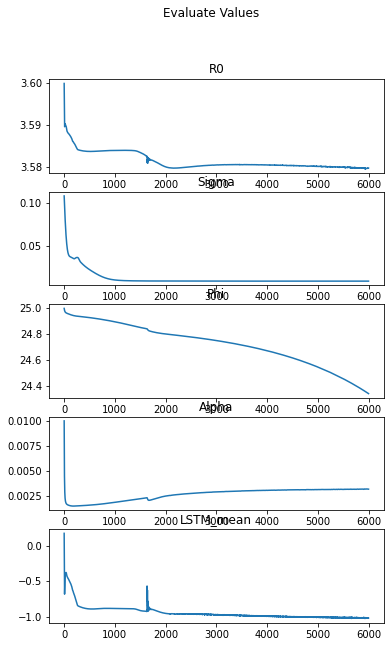

In [ ]:
fig, axs = plt.subplots(5)
fig.suptitle(f'Evaluate Values')
fig.set_figheight(10)
axs[0].plot(R0_vis)
axs[0].title.set_text('R0')
axs[1].plot(sigma_vis)
axs[1].title.set_text('Sigma')
axs[2].plot(phi_vis)
axs[2].title.set_text('Phi')
axs[3].plot(alpha_vis)
axs[3].title.set_text('Alpha')
axs[4].plot(lstm_vis)
axs[4].title.set_text('LSTM_mean')
plt.show()

### Evaluate Loss

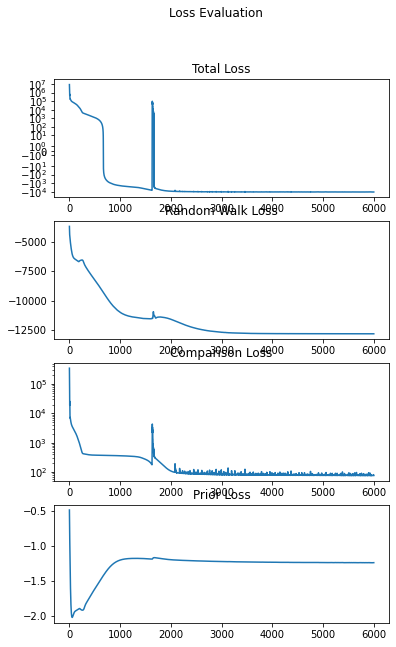

In [ ]:
fig, axs = plt.subplots(4)
fig.suptitle(f'Loss Evaluation')
fig.set_figheight(10)
axs[0].plot(loss_vis)
axs[0].title.set_text('Total Loss')
axs[0].set_yscale('symlog')
axs[1].plot(rw_loss_vis)
axs[1].title.set_text('Random Walk Loss')
axs[2].plot(comp_loss_vis)
axs[2].title.set_text('Comparison Loss')
axs[2].set_yscale('log')
axs[3].plot(prior_loss_vis)
axs[3].title.set_text('Prior Loss')
#axs[3].set_yscale('log')
plt.show()

### Prepare Input Data for Prediction

In [ ]:
max_forecasting_days = 30

#### Prepare Weather Data

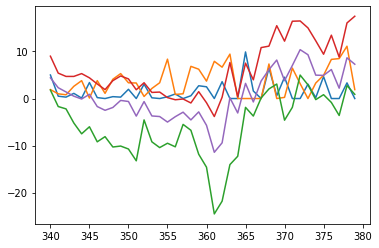

In [ ]:
# first 5 days 90% accuracy, 80% accuracy until day 7 and after that 50% accuracy
np_first_days = np.ones(5) * 0.9
np_7_days = np.ones(2) * 0.8
np_last_days = 1/np.linspace(2, 4, max_forecasting_days-7)
np_noise = 1/np.concatenate((np_first_days, np_7_days, np_last_days))
np_noise

# specifiy detailed noise for rain, sun and temp
rain_noise = np.random.randn(max_forecasting_days)
sun_noise = np.random.randn(max_forecasting_days)
temp_noise = np.random.randn(max_forecasting_days)


import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    df_weather_data_pred = df_weather_data.copy()
    df_weather_data_pred['Hours_of_Rain'][training_days:training_days+max_forecasting_days] = np.max((df_weather_data_pred['Hours_of_Rain'][training_days:training_days+max_forecasting_days] + rain_noise * np_noise, np.zeros(max_forecasting_days)), axis=0)
    df_weather_data_pred['Hours_of_Sun'][training_days:training_days+max_forecasting_days] = np.max((df_weather_data_pred['Hours_of_Sun'][training_days:training_days+max_forecasting_days] + sun_noise * np_noise, np.zeros(max_forecasting_days)), axis=0)
    df_weather_data_pred['Lowest_Temp'][training_days:training_days+max_forecasting_days] = df_weather_data_pred['Lowest_Temp'][training_days:training_days+max_forecasting_days] + temp_noise * np_noise
    df_weather_data_pred['Highest_Temp'][training_days:training_days+max_forecasting_days] = df_weather_data_pred['Highest_Temp'][training_days:training_days+max_forecasting_days] + temp_noise * np_noise
    df_weather_data_pred['Avg_Temp'][training_days:training_days+max_forecasting_days] = df_weather_data_pred['Avg_Temp'][training_days:training_days+max_forecasting_days] + temp_noise * np_noise

plt.plot(df_weather_data_pred[cols_weather][training_days-10:training_days+max_forecasting_days])
plt.show()

#### Prepare Mobility Data

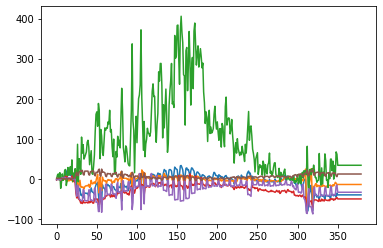

In [ ]:
mob_data_training_np = mob_data[cols_mob][:training_days].to_numpy()
mob_data_mean = np.ones((max_forecasting_days, len(cols_mob))) * np.mean(mob_data_training_np[-7:], 0)
df_mob_data_pred = pd.DataFrame(np.concatenate((mob_data_training_np, mob_data_mean), axis=0), columns=cols_mob).reset_index(drop=True)
plt.plot(df_mob_data_pred)
plt.show()

#### Create Forecasting Input Data

In [ ]:
prediction_data = pd.concat((df_mob_data_pred[cols_mob][:training_days+max_forecasting_days], df_weather_data_pred[cols_weather][:training_days+max_forecasting_days]), axis=1)
np_prediction_data = prediction_data[cols].to_numpy()
np_prediction_data_scaled = scaler.transform(np_prediction_data)
prediction_data_t = torch.tensor(np_prediction_data_scaled, dtype=dtype, device=device)
prediction_data_t.shape

torch.Size([380, 11])

### Show Prediction

In [ ]:
forecasting_days = 28

In [ ]:
with torch.no_grad():
  lstm.hidden_cell = (torch.zeros(1, 1, lstm.hidden_layer_size, dtype=dtype, device=device),
                      torch.zeros(1, 1, lstm.hidden_layer_size, dtype=dtype, device=device))
  predicted_daily_hospit, lstm_prediction, beta_0, eta_t = forward_pass(prediction_data_t, epsilon_t, training_days, forecasting_days=forecasting_days)

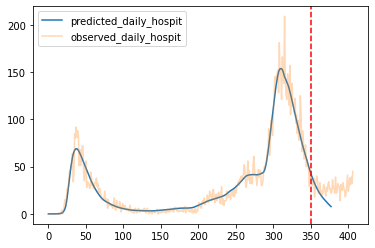

In [ ]:
plt.plot(predicted_daily_hospit.cpu().detach().numpy(), label='predicted_daily_hospit')
#plt.plot(expected_daily_hospit.cpu().detach().numpy(), label='expected_daily_hospit')
plt.plot(observed_daily_hospit.cpu().detach().numpy(), label='observed_daily_hospit', alpha=0.3)
plt.axvline(x=training_days, c='r', linestyle='--')
plt.legend()
plt.show()

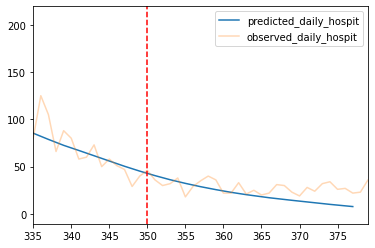

In [ ]:
plt.plot(predicted_daily_hospit.cpu().detach().numpy(), label='predicted_daily_hospit')
plt.plot(observed_daily_hospit.cpu().detach().numpy(), label='observed_daily_hospit', alpha=0.3)
plt.axvline(x=training_days, c='r', linestyle='--')
plt.xlim(training_days-15, training_days+forecasting_days+1)
#plt.ylim(-10, 3000)
plt.legend()
plt.show()

In [ ]:
with torch.no_grad():
  lstm.hidden_cell = (torch.zeros(1, 1, lstm.hidden_layer_size, dtype=dtype, device=device),
                      torch.zeros(1, 1, lstm.hidden_layer_size, dtype=dtype, device=device))
  predicted_daily_hospit_model_data, lstm_prediction, beta_0, eta_t = forward_pass(model_input_data_t, epsilon_t, training_days, forecasting_days=forecasting_days)

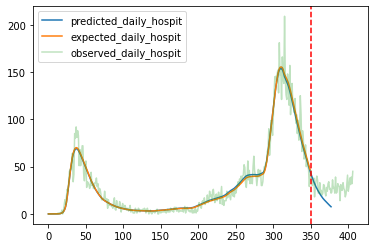

In [ ]:
plt.plot(predicted_daily_hospit_model_data.cpu().detach().numpy(), label='predicted_daily_hospit')
plt.plot(expected_daily_hospit.cpu().detach().numpy(), label='expected_daily_hospit')
plt.plot(observed_daily_hospit.cpu().detach().numpy(), label='observed_daily_hospit', alpha=0.3)
plt.axvline(x=training_days, c='r', linestyle='--')
plt.legend()
plt.show()

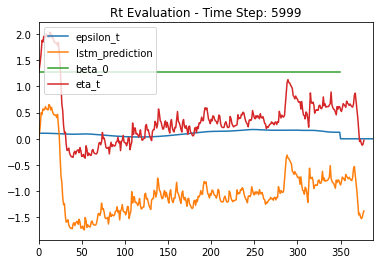

In [ ]:
plt.plot(epsilon_t.cpu().detach().numpy(), label='epsilon_t')
plt.plot(lstm_prediction.cpu().detach().numpy(), label='lstm_prediction')
plt.plot(np.full(training_days, beta_0.cpu().detach().numpy()), label='beta_0')
plt.plot(eta_t.cpu().detach().numpy(), label='eta_t')
plt.title(f'Rt Evaluation - Time Step: {i}')
plt.xlim(0, training_days+forecasting_days+10)
#plt.ylim(-2, 3)
plt.legend(loc='upper left')

### Evaluate Prediction

In [ ]:
eval_horizons = [7, 14, 21, 28]
eval_results = []
for i in eval_horizons:
  actual = observed_daily_hospit[training_days: training_days + i].cpu().detach().numpy()
  predicted = predicted_daily_hospit[training_days: training_days + i].cpu().detach().numpy()
  mae = mean_absolute_error(actual, predicted)
  eval_results.append((i, mae))
eval_results

[(7, 5.673446), (14, 6.013114), (21, 6.6818733), (28, 9.36991)]